# Mapping seqeuencing, identifying capped, and or chimeric


In [2]:
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import pandas as pd
import numpy as np

from scipy import stats

from statsmodels.stats import multitest
import numpy as np
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats

%matplotlib inline
scripts = 'Scripts'
import seaborn as sns
import glob
sys.path.append(scripts)
import fastQHandling
import ccRNAprocess
adapterFile = 'Database/adapter.fa'
sequenceDirectory = "Sequencing/"
genome = 'Database/WSN_star'
ccRNAseqs = 'Database/ccRNAends.csv'
resultsDir = 'Results'
if not os.path.isdir(resultsDir):
    os.mkdir(resultsDir)
    
    #multiprocessing for mapping to speed things up a bit
from multiprocessing import Pool
numProcessors = 4
import subprocess
#some parameters for plotting

figureDirectory = 'Figures/'
if not os.path.isdir(figureDirectory):
    os.mkdir(figureDirectory)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 16, 'axes.titlesize':'medium',})
sns.set_style("white")
sns.set_style("ticks")
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

colormap = 'colorblind'
colors = sns.color_palette(colormap, 8)
segments = ['PB1_vRNA','HA_vRNA','PB2_vRNA',  'PA_vRNA','NP_vRNA','NA_vRNA','M_vRNA','NS_vRNA']
fluColors = {}
for color, segment in enumerate(segments):
    fluColors[segment] = colors[color]
segments = ['PB2_vRNA', 'PB1_vRNA', 'PA_vRNA','HA_vRNA','NP_vRNA','NA_vRNA','M_vRNA','NS_vRNA']
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 12, 'axes.titlesize':'medium',})
#length of read to use for segment identity
alignLen = 159

TSOrc = 'ATGTACTCTGCGTTGATACC'


# Mapping

In [2]:


experiments = []
for file in glob.glob(sequenceDirectory + '/*.fastq*'):
    fileName = file.split('/')[-1]
    descriptors = fileName.split('_')
    replicate = descriptors[1]
    virus = descriptors[0]
    read = descriptors[-2]
    #for this paper, currently only 1 run per experiment, but might as well add some flexibility.
    sequencingRun = descriptors[-3]
    experiments += [pd.DataFrame({'replicate':[replicate],
                                  'virus':[virus],
                                  'read_pair':[read], 
                                  'file_name':[file], 'sequencing_run':[sequencingRun]})]
experiments = pd.concat(experiments).reset_index().drop(columns=['index'])
unique = experiments.groupby([ 'virus', 'replicate']).file_name.apply(list).reset_index()
experiments.set_index(['replicate', 'virus'])



read_pair                                  file_name  \
replicate virus                                                        
1         Tmut         R1  Sequencing/Tmut_1_S4_L001_R1_001.fastq.gz   
          Tmut         R2  Sequencing/Tmut_1_S4_L001_R2_001.fastq.gz   
2         Tmut         R1  Sequencing/Tmut_2_S5_L001_R1_001.fastq.gz   
          Tmut         R2  Sequencing/Tmut_2_S5_L001_R2_001.fastq.gz   
3         Tmut         R1  Sequencing/Tmut_3_S6_L001_R1_001.fastq.gz   
          Tmut         R2  Sequencing/Tmut_3_S6_L001_R2_001.fastq.gz   
1         WT           R1    Sequencing/WT_1_S1_L001_R1_001.fastq.gz   
          WT           R2    Sequencing/WT_1_S1_L001_R2_001.fastq.gz   
2         WT           R1    Sequencing/WT_2_S2_L001_R1_001.fastq.gz   
          WT           R2    Sequencing/WT_2_S2_L001_R2_001.fastq.gz   
3         WT           R1    Sequencing/WT_3_S3_L001_R1_001.fastq.gz   
          WT           R2    Sequencing/WT_3_S3_L001_R2_001.fastq.gz   

                sequencing_run  
replicate virus                 
1         Tmut            L001  
          Tmut            L001  
2         Tmut            L001  
          Tmut            L001  
3         Tmut            L001  
          Tmut            L001  
1         WT              L001  
          WT              L001  
2         WT              L001  
          WT              L001  
3         WT              L001  
          WT              L001

sequencing stats


In [10]:


def fastQC(tupleArgument):
    sampleName = tupleArgument[0]
    reads = tupleArgument[1]
    return {sampleName:fastQHandling.fastQCreport(sampleName=sampleName, reads=reads)}
figsDisplay = []
reports = []
results = {}
samples = {}
for index, row in experiments.iterrows():
    sample = '_'.join([str(row.replicate), row.virus])
    read = row.file_name
    readName = row.sequencing_run + '_' + row.read_pair
    if sample not in samples.keys():
        samples[sample] = {readName:read}
    else:
        samples[sample][readName] = read
popList = [(sample, samples[sample]) for sample in list(samples.keys())]
while len(popList) > 0:
    with Pool(processes = numProcessors) as p:
        reports += p.map(fastQC, [popList.pop() for i in range(numProcessors) if len(popList) != 0])
reports = {key:value for dictionary in reports for key, value in dictionary.items()} 
a = fastQHandling.graphAllTheThings(data=reports, title='sorting QC')
#pdf for publication
plt.savefig(sequenceDirectory + '/sequenceQC.pdf', format='pdf', bbox_inches = "tight")
#png for showing here
plt.savefig(sequenceDirectory + '/sequenceQC.png', format='png', bbox_inches = "tight")
plt.close()
figsDisplay += [sequenceDirectory + '/sequenceQC.png']
width = 128 * len(figsDisplay)
g = plt.figure(1, (width, 128))
spec = g.add_gridspec(ncols= len(figsDisplay),nrows=1)
for column, fig in enumerate(figsDisplay):
    ax = g.add_subplot(spec[0,column])
    img=mpimg.imread(fig)
    ax.imshow(img)
    ax.axis('off')



Started analysis of WT_2_S2_L001_R1_001.fastq.gz
Started analysis of WT_3_S3_L001_R1_001.fastq.gz
Started analysis of Tmut_3_S6_L001_R1_001.fastq.gz
Started analysis of WT_1_S1_L001_R1_001.fastq.gz
Approx 5% complete for Tmut_3_S6_L001_R1_001.fastq.gz
Approx 5% complete for WT_2_S2_L001_R1_001.fastq.gz
Approx 5% complete for WT_3_S3_L001_R1_001.fastq.gz
Approx 5% complete for WT_1_S1_L001_R1_001.fastq.gz
Approx 10% complete for Tmut_3_S6_L001_R1_001.fastq.gz
Approx 10% complete for WT_2_S2_L001_R1_001.fastq.gz
Approx 10% complete for WT_3_S3_L001_R1_001.fastq.gz
Approx 10% complete for WT_1_S1_L001_R1_001.fastq.gz
Approx 15% complete for Tmut_3_S6_L001_R1_001.fastq.gz
Approx 15% complete for WT_1_S1_L001_R1_001.fastq.gz
Approx 15% complete for WT_2_S2_L001_R1_001.fastq.gz
Approx 15% complete for WT_3_S3_L001_R1_001.fastq.gz
Approx 20% complete for WT_1_S1_L001_R1_001.fastq.gz
Approx 20% complete for Tmut_3_S6_L001_R1_001.fastq.gz
Approx 20% complete for WT_2_S2_L001_R1_001.fastq.gz
App

Analysis complete for WT_1_S1_L001_R1_001.fastq.gz


Approx 80% complete for WT_2_S2_L001_R1_001.fastq.gz
Approx 85% complete for Tmut_3_S6_L001_R1_001.fastq.gz
Approx 80% complete for WT_3_S3_L001_R1_001.fastq.gz
Approx 90% complete for Tmut_3_S6_L001_R1_001.fastq.gz
Approx 85% complete for WT_2_S2_L001_R1_001.fastq.gz
Approx 85% complete for WT_3_S3_L001_R1_001.fastq.gz
Approx 95% complete for Tmut_3_S6_L001_R1_001.fastq.gz
Approx 90% complete for WT_2_S2_L001_R1_001.fastq.gz
Approx 90% complete for WT_3_S3_L001_R1_001.fastq.gz


Analysis complete for Tmut_3_S6_L001_R1_001.fastq.gz


Approx 95% complete for WT_2_S2_L001_R1_001.fastq.gz
Approx 95% complete for WT_3_S3_L001_R1_001.fastq.gz


Analysis complete for WT_2_S2_L001_R1_001.fastq.gz
Analysis complete for WT_3_S3_L001_R1_001.fastq.gz


Started analysis of WT_1_S1_L001_R2_001.fastq.gz
Started analysis of WT_2_S2_L001_R2_001.fastq.gz
Approx 5% complete for WT_1_S1_L001_R2_001.fastq.gz
Started analysis of Tmut_3_S6_L001_R2_001.fastq.gz
Approx 10% complete for WT_1_S1_L001_R2_001.fastq.gz
Approx 5% complete for WT_2_S2_L001_R2_001.fastq.gz
Started analysis of WT_3_S3_L001_R2_001.fastq.gz
Approx 15% complete for WT_1_S1_L001_R2_001.fastq.gz
Approx 10% complete for WT_2_S2_L001_R2_001.fastq.gz
Approx 5% complete for Tmut_3_S6_L001_R2_001.fastq.gz
Approx 20% complete for WT_1_S1_L001_R2_001.fastq.gz
Approx 5% complete for WT_3_S3_L001_R2_001.fastq.gz
Approx 15% complete for WT_2_S2_L001_R2_001.fastq.gz
Approx 10% complete for Tmut_3_S6_L001_R2_001.fastq.gz
Approx 25% complete for WT_1_S1_L001_R2_001.fastq.gz
Approx 20% complete for WT_2_S2_L001_R2_001.fastq.gz
Approx 10% complete for WT_3_S3_L001_R2_001.fastq.gz
Approx 30% complete for WT_1_S1_L001_R2_001.fastq.gz
Approx 15% complete for Tmut_3_S6_L001_R2_001.fastq.gz
Appro

Analysis complete for WT_1_S1_L001_R2_001.fastq.gz


Approx 80% complete for WT_2_S2_L001_R2_001.fastq.gz
Approx 70% complete for Tmut_3_S6_L001_R2_001.fastq.gz
Approx 65% complete for WT_3_S3_L001_R2_001.fastq.gz
Approx 85% complete for WT_2_S2_L001_R2_001.fastq.gz
Approx 75% complete for Tmut_3_S6_L001_R2_001.fastq.gz
Approx 70% complete for WT_3_S3_L001_R2_001.fastq.gz
Approx 90% complete for WT_2_S2_L001_R2_001.fastq.gz
Approx 80% complete for Tmut_3_S6_L001_R2_001.fastq.gz
Approx 75% complete for WT_3_S3_L001_R2_001.fastq.gz
Approx 95% complete for WT_2_S2_L001_R2_001.fastq.gz
Approx 85% complete for Tmut_3_S6_L001_R2_001.fastq.gz
Approx 80% complete for WT_3_S3_L001_R2_001.fastq.gz


Analysis complete for WT_2_S2_L001_R2_001.fastq.gz


Approx 90% complete for Tmut_3_S6_L001_R2_001.fastq.gz
Approx 85% complete for WT_3_S3_L001_R2_001.fastq.gz
Approx 95% complete for Tmut_3_S6_L001_R2_001.fastq.gz
Approx 90% complete for WT_3_S3_L001_R2_001.fastq.gz


Analysis complete for Tmut_3_S6_L001_R2_001.fastq.gz


Approx 95% complete for WT_3_S3_L001_R2_001.fastq.gz


Analysis complete for WT_3_S3_L001_R2_001.fastq.gz


Started analysis of Tmut_1_S4_L001_R1_001.fastq.gz
Started analysis of Tmut_2_S5_L001_R1_001.fastq.gz
Approx 5% complete for Tmut_2_S5_L001_R1_001.fastq.gz
Approx 5% complete for Tmut_1_S4_L001_R1_001.fastq.gz
Approx 10% complete for Tmut_2_S5_L001_R1_001.fastq.gz
Approx 10% complete for Tmut_1_S4_L001_R1_001.fastq.gz
Approx 15% complete for Tmut_2_S5_L001_R1_001.fastq.gz
Approx 15% complete for Tmut_1_S4_L001_R1_001.fastq.gz
Approx 20% complete for Tmut_2_S5_L001_R1_001.fastq.gz
Approx 20% complete for Tmut_1_S4_L001_R1_001.fastq.gz
Approx 25% complete for Tmut_2_S5_L001_R1_001.fastq.gz
Approx 25% complete for Tmut_1_S4_L001_R1_001.fastq.gz
Approx 30% complete for Tmut_2_S5_L001_R1_001.fastq.gz
Approx 30% complete for Tmut_1_S4_L001_R1_001.fastq.gz
Approx 35% complete for Tmut_2_S5_L001_R1_001.fastq.gz
Approx 35% complete for Tmut_1_S4_L001_R1_001.fastq.gz
Approx 40% complete for Tmut_2_S5_L001_R1_001.fastq.gz
Approx 45% complete for Tmut_2_S5_L001_R1_001.fastq.gz
Approx 40% complete 

Analysis complete for Tmut_2_S5_L001_R1_001.fastq.gz


Approx 90% complete for Tmut_1_S4_L001_R1_001.fastq.gz
Approx 95% complete for Tmut_1_S4_L001_R1_001.fastq.gz


Analysis complete for Tmut_1_S4_L001_R1_001.fastq.gz


Started analysis of Tmut_2_S5_L001_R2_001.fastq.gz
Approx 5% complete for Tmut_2_S5_L001_R2_001.fastq.gz
Started analysis of Tmut_1_S4_L001_R2_001.fastq.gz
Approx 10% complete for Tmut_2_S5_L001_R2_001.fastq.gz
Approx 15% complete for Tmut_2_S5_L001_R2_001.fastq.gz
Approx 5% complete for Tmut_1_S4_L001_R2_001.fastq.gz
Approx 20% complete for Tmut_2_S5_L001_R2_001.fastq.gz
Approx 10% complete for Tmut_1_S4_L001_R2_001.fastq.gz
Approx 25% complete for Tmut_2_S5_L001_R2_001.fastq.gz
Approx 15% complete for Tmut_1_S4_L001_R2_001.fastq.gz
Approx 30% complete for Tmut_2_S5_L001_R2_001.fastq.gz
Approx 20% complete for Tmut_1_S4_L001_R2_001.fastq.gz
Approx 35% complete for Tmut_2_S5_L001_R2_001.fastq.gz
Approx 25% complete for Tmut_1_S4_L001_R2_001.fastq.gz
Approx 40% complete for Tmut_2_S5_L001_R2_001.fastq.gz
Approx 30% complete for Tmut_1_S4_L001_R2_001.fastq.gz
Approx 45% complete for Tmut_2_S5_L001_R2_001.fastq.gz
Approx 35% complete for Tmut_1_S4_L001_R2_001.fastq.gz
Approx 50% complete 

Analysis complete for Tmut_2_S5_L001_R2_001.fastq.gz


Approx 80% complete for Tmut_1_S4_L001_R2_001.fastq.gz
Approx 85% complete for Tmut_1_S4_L001_R2_001.fastq.gz
Approx 90% complete for Tmut_1_S4_L001_R2_001.fastq.gz
Approx 95% complete for Tmut_1_S4_L001_R2_001.fastq.gz


Analysis complete for Tmut_1_S4_L001_R2_001.fastq.gz


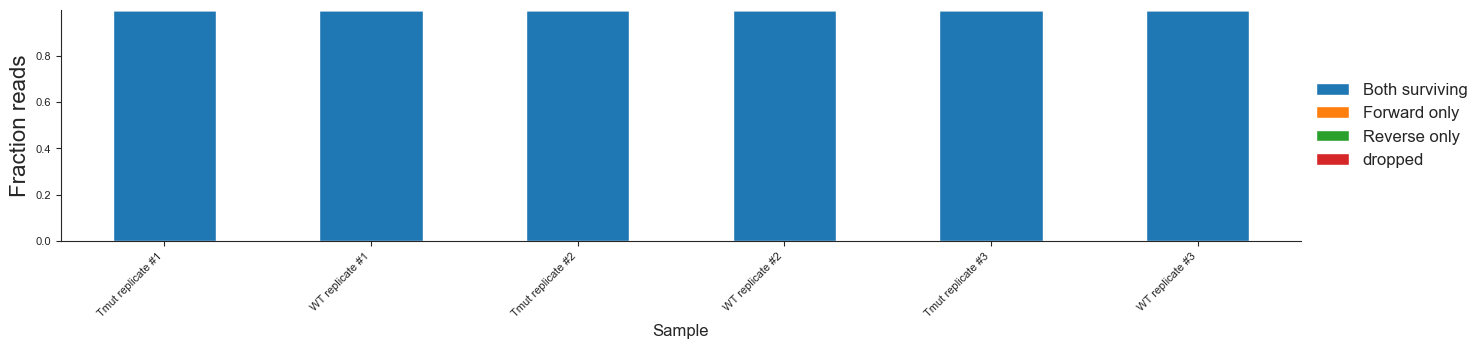

In [4]:


#list comprehension to get reports on trimming statistics. Using baseline recommendations of program creators.
#Can overwrite if need be. Does not rerun if already run in past, only grabs statistics. Pass rerun=True, if overwrite
#is desired.
if not os.path.isdir('/'.join([sequenceDirectory, 'trimmed_reads'])):
    os.mkdir('/'.join([sequenceDirectory, 'trimmed_reads']))
rows = experiments.groupby([ 'replicate', 'virus','sequencing_run']).file_name.apply(list).reset_index().iterrows()
stats = pd.concat([fastQHandling.trimCommandPaired(read1=row[1].file_name[0], 
                           read2= row[1].file_name[1],
                           outDirectory='/'.join([sequenceDirectory, 'trimmed_reads']),
                            adapterFile= adapterFile,
                            sampleName = ''.join([row[1].virus,' replicate #', str(row[1].replicate)]),
                          threads = numProcessors,crop=alignLen) for row in rows]).set_index('Sample')
#return raw numbers from above as they are generally more useful, but go ahead and collapse to percentages here
stats=stats.div(stats['Input read pairs'], axis=0).drop(columns=['Input read pairs'])
ax = stats.loc[:,['Both surviving', 'Forward only', 'Reverse only', 'dropped']].plot.bar(stacked=True,figsize=(16,3), fontsize=8)
sns.despine()
ax.legend( loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.xticks(rotation=45,horizontalalignment="right")
plt.ylabel('Fraction reads', fontsize=16)
plt.savefig(sequenceDirectory + '/trimming_statistics.pdf', format='pdf', bbox_inches = "tight")



In [30]:


for index, row in experiments.groupby(['replicate', 'virus']).file_name.apply(list).reset_index().iterrows():
    #making sure pipeline supports multiple sequencing runs.
    virus = row.virus
    replicate = row.replicate
    sequences = experiments[(experiments.replicate == replicate) & (experiments.virus == virus)]
    outDirectory = resultsDir + '/STARalign'
    if not os.path.isdir(outDirectory):
        os.mkdir(outDirectory)
    #collate all R1s and associated R2s. ORDER CRITICAL, hence the whole song and dance here
    R1 = []
    R2 = []
    for index, row in sequences[sequences.read_pair == 'R1'].iterrows():
        read1 = row.file_name
        read2 = sequences[(sequences.sequencing_run == row.sequencing_run) & (
                sequences.read_pair == 'R2')].file_name.iloc[0]
        R1 += ['/'.join(read1.split('/')[:-1]) + '/trimmed_reads/' +read1.split('/')[-1]]
        R2 += ['/'.join(read2.split('/')[:-1]) + '/trimmed_reads/' +read2.split('/')[-1]]
    outprefix = outDirectory + '/' + str(virus) + '-' + str(replicate) 
    for read in R1 + R2:
        unzipped = read[:-3]
        !gunzip -c $read > $unzipped
    read1unzip = ','.join([read[:-3] for read in R1])
    read2unzip = ','.join([read[:-3] for read in R2])
    outprefix1 = outprefix + '_R1_'
    outprefix2 = outprefix + '_R2_'
    logFile1 =  outprefix1 + 'terminal.txt'
    logFile2 =  outprefix2 + 'terminal.txt'
    #single threaded to preserve read order
    capture1 = !STAR --runMode alignReads --runThreadN 1 --genomeDir $genome --readFilesIn $read1unzip --outFileNamePrefix $outprefix1 --outSAMtype BAM Unsorted   --alignSJoverhangMin 1000  --outFilterMismatchNmax 3 --scoreDelOpen -6 --scoreDelBase -6 --alignEndsType EndToEnd --outSAMunmapped Within
    capture2 = !STAR --runMode alignReads --runThreadN 1 --genomeDir $genome --readFilesIn $read2unzip --outFileNamePrefix $outprefix2 --outSAMtype BAM Unsorted   --alignSJoverhangMin 1000  --outFilterMismatchNmax 3 --scoreDelOpen -6 --scoreDelBase -6 --alignEndsType EndToEnd --outSAMunmapped Within

    with open(logFile1, 'w') as outfile1, open(logFile2, 'w') as outfile2:
        for line in capture1:
            outfile1.write(line + '\n')
        for line in capture2:
            outfile2.write(line + '\n')

    for read in R1 + R2:
        unzipped = read[:-3]
        !rm -f $unzipped



# Assignment

So now know what segments any given reads map to, we are just going to look in R1, then for TSO (if no TSO, check if recircularized vRNA/cRNA), then distance for TSO.

just require perfect matches to 20nt at 3' and 5' end, record distance in read to account for anything odd, mark chimeras, presence of TSO (req 15nt, look in R1 only).


In [31]:
def runCode(row):
    #unzip, unbam
    fq1gz = row.file_name[0]
    fq2gz = row.file_name[1]
    fq1 =  fq1gz[:-3]
    fq2 = fq2gz[:-3]
    !gunzip -c $fq1gz > $fq1
    !gunzip -c $fq2gz > $fq2
    bf1 = resultsDir + '/STARalign/' + str(row.virus) + '-' + str(row.replicate) + '_R1_Aligned.out.bam'
    bf2 = resultsDir + '/STARalign/' + str(row.virus) + '-' + str(row.replicate) + '_R2_Aligned.out.bam'
    sf1 = bf1[:-3] + 'sam'
    sf2 = bf2[:-3] + 'sam'
    !samtools view $bf1 > $sf1
    !samtools view $bf2 > $sf2
    outFile = outDir + str(row.virus) + '-' + str(row.replicate) + '_ProcessedCounts.csv'
    ccRNAprocess.assignReads(matchChart = ccRNAseqs, TSOseq=TSOrc, R1fastq = fq1, R2fastq = fq2,
                             R1samfile = sf1, R2samfile = sf2, outFile = outFile)
    !rm -rf $fq1
    !rm -rf $fq2
    !rm -rf $sf1
    !rm -rf $sf2
                             
outDir = resultsDir + '/ProcessedccRNA/'
if not os.path.isdir(outDir):
    os.mkdir(outDir)
unique.apply(lambda row: runCode(row), axis=1)
    


0    None
1    None
2    None
3    None
4    None
5    None
dtype: object

# Graphing, analysis

In [5]:
#load in alldata, but also the "correct" distances for the 5' mapping of the cRNA to confirm nothing odd
parameters=pd.read_csv('Database/ccRNAends.csv')
data = []
for file in glob.glob('Results/ProcessedccRNA/*_ProcessedCounts.csv'):
    currData = pd.read_csv(file)
    virus = file.split('/')[-1].split('-')[0]
    replicate =  file.split('/')[-1].split('-')[1].split('_')[0]
    currData['virus'] = virus
    currData['replicate'] = replicate
    data += [currData]
data = pd.concat(data)
data['R1_dist'] = data.apply(lambda row: row.R1_dist - 
        parameters[parameters.Segment == row.Segment_1].R1_dist.iloc[0], axis=1)


data['R2_dist'] = data.apply(lambda row: row.R2_dist - 
        parameters[parameters.Segment == row.Segment_1].R2_dist.iloc[0], axis=1)



Chimeras are rare, so template switching unlikely to explain data.

In [8]:
len(data[data.Segment_1 != data.Segment_2])

9

In [9]:
len(data)

21730

In [4]:
data = data[(abs(data.R1_dist) < 3) & (abs(data.R2_dist) < 3) &
            (data.TSO_space != -1) & (data.Segment_1 == data.Segment_2)]
data['TSO_space'] = data.TSO_space -4

In [4]:
data['cRNA'] = data.TSO_space < 3
data['ccRNA'] = (data.TSO_space > 10) & (data.TSO_space <21)
data = data[(data.cRNA) | (data.ccRNA)]

In [143]:
test = data.groupby(['replicate','Segment_1','virus']).mean().reset_index()
test = test[test.Segment_1.isin(['PB2_vRNA','PB1_vRNA','PA_vRNA','NS_vRNA'])]
test['ratio'] = test.ccRNA/test.cRNA

test

[False False  True  True]


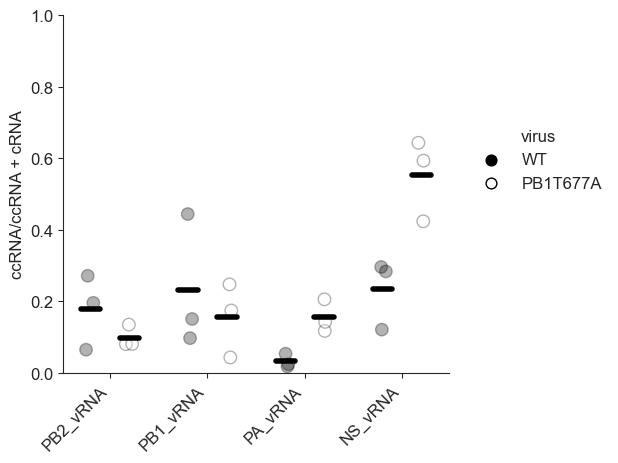

In [144]:

order = ['PB2_vRNA', 'PB1_vRNA', 'PA_vRNA','NS_vRNA']

ax=sns.stripplot(x='Segment_1', y='ccRNA', data=test,  edgecolor='black', order = order,
            jitter=True, dodge=True, linewidth=1, s=9, hue="virus", hue_order=['WT','Tmut'],palette=['0','1'], alpha = 0.3)

sns.despine()
handles, labels = ax.get_legend_handles_labels()
plt.xlabel('')
a =plt.xticks(np.arange(0,9,1),order,rotation=45, ha='right')


ax.legend(handles[0:2], ['WT','PB1T677A'], bbox_to_anchor=(1.05, 0.7), loc=2, borderaxespad=0.,frameon=False, title='virus')

plt.ylabel('ccRNA/ccRNA + cRNA')
a =plt.xticks(np.arange(0,9,1),order,rotation=45, ha='right')
ax.set_ylim(0,1)

for legend_handle in ax.get_legend().legendHandles:  
       legend_handle.set_edgecolor('black')
sns.despine()
pvals = []
for position, segment in enumerate(order):
    curr = test[test['Segment_1'] == segment]
    first = curr[curr.virus == 'WT'].ccRNA
    y = first.mean()
    plt.plot([position-0.3, position-0.1], [y, y], lw=4, c='k', zorder=9)
    second = curr[curr.virus == 'Tmut'].ccRNA
    y = second.mean()
    plt.plot([position+0.1, position+0.3], [y, y], lw=4, c='k', zorder=9)
    stat, pval = stats.ttest_ind(first,second)
    pvals += [pval]
pvals = multitest.multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[0]
print(pvals)
plt.tight_layout()
plt.savefig('ccRNAseq.pdf')

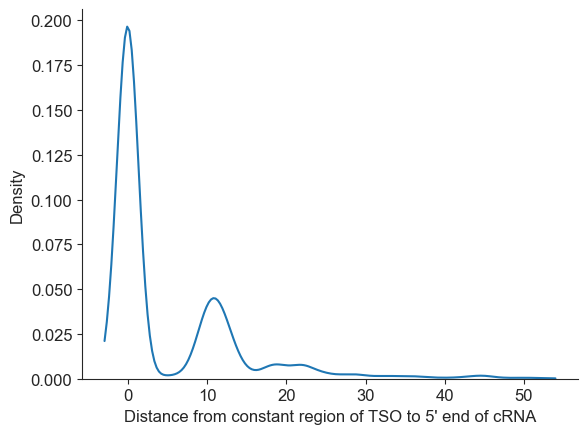

In [5]:
sns.kdeplot(data=data, x="TSO_space", bw_adjust=1, cut=0)
sns.despine()
plt.xlabel('Distance from constant region of TSO to 5\' end of cRNA')
plt.savefig('TSO-distance.pdf')

In [5]:
data

,Unnamed: 0,Segment_1,Segment_2,R1_dist,R2_dist,TSO_space,virus,replicate,cRNA,ccRNA
4,0,NS_vRNA,NS_vRNA,0,0,0,Tmut,1,True,False
5,0,NS_vRNA,NS_vRNA,0,0,11,Tmut,1,False,True
6,0,NS_vRNA,NS_vRNA,0,0,0,Tmut,1,True,False
7,0,PB1_vRNA,PB1_vRNA,0,0,0,Tmut,1,True,False
9,0,PB1_vRNA,PB1_vRNA,0,0,-1,Tmut,1,True,False
...,...,...,...,...,...,...,...,...,...,...
2700,0,NS_vRNA,NS_vRNA,0,0,0,WT,3,True,False
2706,0,NS_vRNA,NS_vRNA,0,0,0,WT,3,True,False
2707,0,NS_vRNA,NS_vRNA,0,0,0,WT,3,True,False
2709,0,NS_vRNA,NS_vRNA,0,0,0,WT,3,True,False


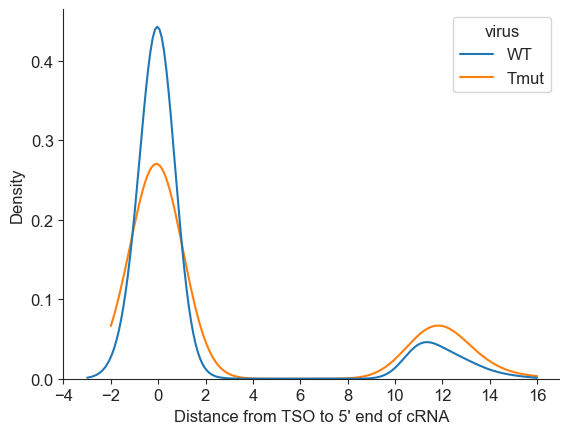

In [23]:
ax = sns.kdeplot(data=data[data.TSO_space < 17], x="TSO_space", bw_adjust=1, cut=0, hue='virus', common_norm=False, hue_order=['WT','Tmut'])
sns.despine()
handles, labels = ax.get_legend_handles_labels()
plt.xlabel('')
plt.xticks(np.arange(-4,17,2))

plt.xlabel('Distance from TSO to 5\' end of cRNA')
plt.savefig('TSO-distanceHighendCutHueVirus.pdf')

In [22]:
ax.get_legend_handles_labels()

([], [])

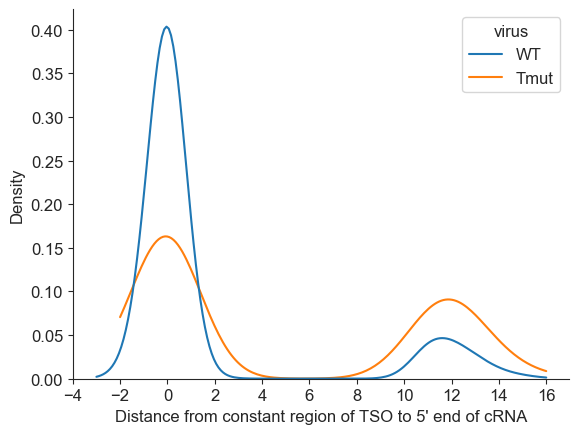

In [24]:
graph = data[data.Segment_1.isin( ['NS_vRNA'])]
sns.kdeplot(data=graph[graph.TSO_space < 17], x="TSO_space", bw_adjust=1, cut=0, hue='virus', common_norm=False,hue_order=['WT','Tmut'])
sns.despine()
plt.xticks(np.arange(-4,17,2))
plt.xlabel('Distance from constant region of TSO to 5\' end of cRNA')
plt.savefig('TSO-distanceHighendCutHueVirusOnlyNS.pdf')

(array([False, False, False, False]), array([0.35447366, 0.51809806, 0.07251275, 0.07251275]), 0.012741455098566168, 0.0125)


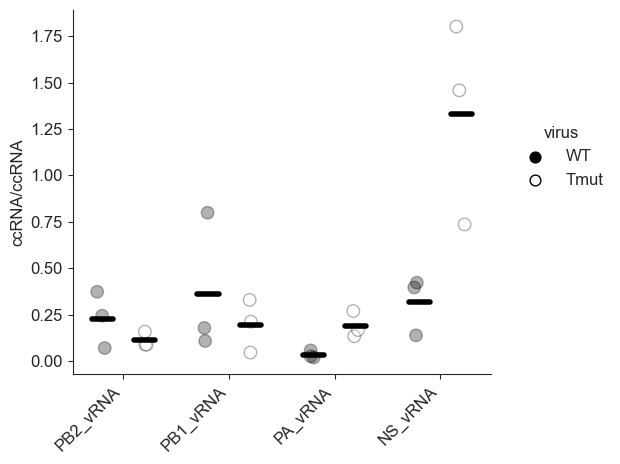

In [115]:
order = ['PB2_vRNA', 'PB1_vRNA', 'PA_vRNA','NS_vRNA']

ax=sns.stripplot(x='Segment_1', y='ratio', data=test,  edgecolor='black', order = order,
            jitter=True, dodge=True, linewidth=1, s=9, hue="virus", hue_order=['WT','Tmut'],palette=['0','1'], alpha = 0.3)

sns.despine()
handles, labels = ax.get_legend_handles_labels()
plt.xlabel('')


ax.legend(handles[0:2], ['WT','Tmut'], bbox_to_anchor=(1.05, 0.7), loc=2, borderaxespad=0.,frameon=False, title='virus')

plt.ylabel('ccRNA/ccRNA')
a =plt.xticks(np.arange(0,9,1),order,rotation=45, ha='right')

for legend_handle in ax.get_legend().legendHandles:  
       legend_handle.set_edgecolor('black')
sns.despine()
pvals = []
for position, segment in enumerate(order):
    curr = test[test['Segment_1'] == segment]
    first = curr[curr.virus == 'WT'].ratio
    y = first.mean()
    plt.plot([position-0.3, position-0.1], [y, y], lw=4, c='k', zorder=9)
    second = curr[curr.virus == 'Tmut'].ratio
    y = second.mean()
    plt.plot([position+0.1, position+0.3], [y, y], lw=4, c='k', zorder=9)
    stat, pval = stats.ttest_ind(first,second)
    pvals += [pval]
pvals = multitest.multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
print(pvals)
plt.tight_layout()